# 머신러닝을 이용한 주가 예측

# Load Library

In [1]:
import warnings;warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from lightgbm import LGBMRegressor

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12
}
# plt.rcParams.update(dark_style)

# Load Data

In [2]:
sm_stock=pd.read_csv('D:/이직준비공부/AI/project_1/data/전처리_완료_데이터/주가/SM_ent.csv')
jyp_stock=pd.read_csv('D:/이직준비공부/AI/project_1/data/전처리_완료_데이터/주가/JYP_ent.csv')
yg_stock=pd.read_csv('D:/이직준비공부/AI/project_1/data/전처리_완료_데이터/주가/YG_ent.csv')

# Data Pre-Processing

In [3]:
# 날짜 데이터 타입 변경 (str => datetime)
def change_dtype_sort(df):
    df['날짜']=pd.to_datetime(df['날짜'])
    df.sort_values(by='날짜',inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.columns=['', '종가', '오픈', '고가', '저가', '거래량','변동 %']
    df.set_index('',inplace=True)
    return df

In [4]:
# 날짜 인덱스에서 공백없이 데이터 재구성
def make_date_freq_null_processing(df):
    df=df.asfreq('D')
    df['종가'].fillna(method='ffill',inplace=True)
    df['거래량'].fillna(0,inplace=True)
    df['변동 %'].fillna(0,inplace=True)
    for idx in df.index:
        for col in ['오픈','고가','저가']:
            if pd.notnull(df.loc[idx,col])==True:
                pass
            else:
                df.loc[idx,col]=df.loc[idx,'종가']
    return df

In [5]:
sm_stock_for_sk=make_date_freq_null_processing(change_dtype_sort(sm_stock))
jyp_stock_for_sk=make_date_freq_null_processing(change_dtype_sort(jyp_stock))
yg_stock_for_sk=make_date_freq_null_processing(change_dtype_sort(yg_stock))

# Data Visualize

In [6]:
sm_train=sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.7),:]
sm_val=sm_stock_for_sk.iloc[round(len(sm_stock_for_sk)*0.7):round(len(sm_stock_for_sk)*0.9),:]
sm_test=sm_stock_for_sk.iloc[round(len(sm_stock_for_sk)*0.9):,:]

In [7]:
jyp_train=jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.7),:]
jyp_val=jyp_stock_for_sk.iloc[round(len(jyp_stock_for_sk)*0.7):round(len(jyp_stock_for_sk)*0.9),:]
jyp_test=jyp_stock_for_sk.iloc[round(len(jyp_stock_for_sk)*0.9):,:]

In [8]:
yg_train=yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.7),:]
yg_val=yg_stock_for_sk.iloc[round(len(yg_stock_for_sk)*0.7):round(len(yg_stock_for_sk)*0.9),:]
yg_test=yg_stock_for_sk.iloc[round(len(yg_stock_for_sk)*0.9):,:]

## SM

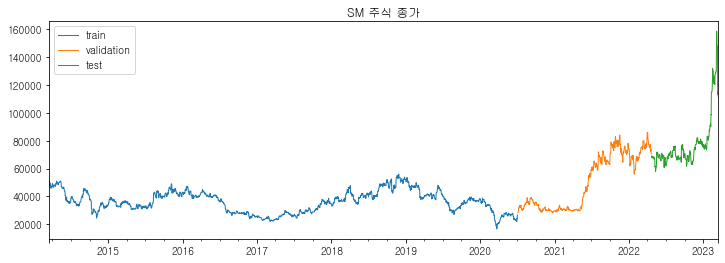

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sm_train['종가'].plot(ax=ax, label='train', linewidth=1)
sm_val['종가'].plot(ax=ax, label='validation', linewidth=1)
sm_test['종가'].plot(ax=ax, label='test', linewidth=1)
ax.set_title('SM 주식 종가')
ax.legend()
plt.show()

## JYP

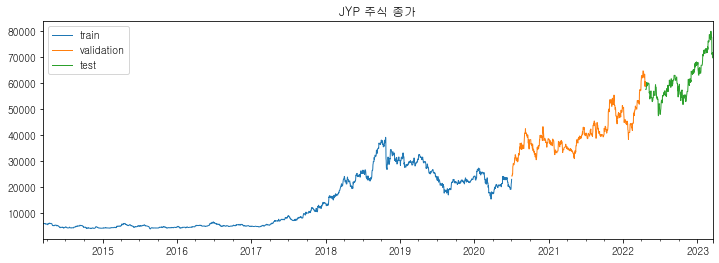

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
jyp_train['종가'].plot(ax=ax, label='train', linewidth=1)
jyp_val['종가'].plot(ax=ax, label='validation', linewidth=1)
jyp_test['종가'].plot(ax=ax, label='test', linewidth=1)
ax.set_title('JYP 주식 종가')
ax.legend()
plt.show()

## YG

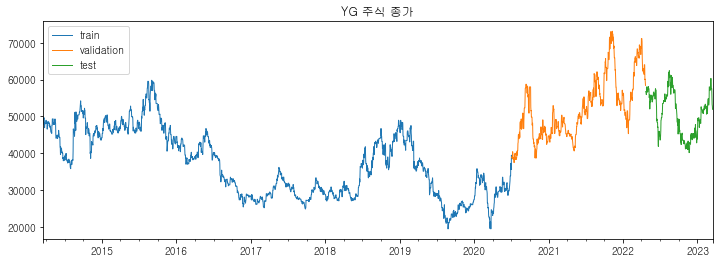

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
yg_train['종가'].plot(ax=ax, label='train', linewidth=1)
yg_val['종가'].plot(ax=ax, label='validation', linewidth=1)
yg_test['종가'].plot(ax=ax, label='test', linewidth=1)
ax.set_title('YG 주식 종가')
ax.legend()
plt.show()

# Recursive autoregressive forecasting

## Forecaster Training

### SM

In [12]:
sm_forecaster = ForecasterAutoreg(
                 regressor     = LGBMRegressor(random_state=123),
                 lags          = 10,
                 transformer_y = StandardScaler(),
                 transformer_exog= StandardScaler()
             )

sm_forecaster.fit(y=sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.9),0],exog=sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.9),1:])

In [13]:
sm_pred=sm_forecaster.predict(steps=round(len(sm_stock_for_sk)*0.1),
                             exog=sm_test[['오픈', '고가', '저가', '거래량', '변동 %']])

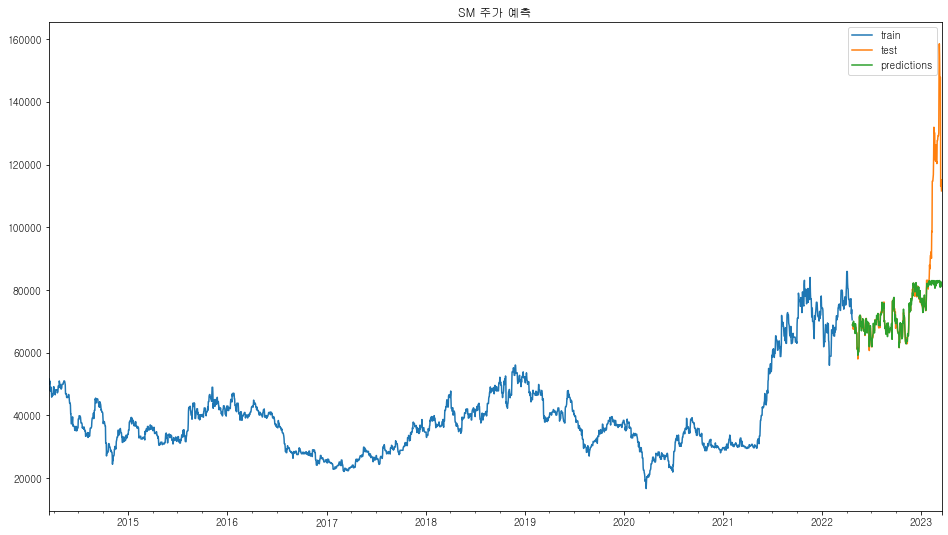

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.9),0].plot(ax=ax, label='train')
sm_test['종가'].plot(ax=ax, label='test')
sm_pred.plot(ax=ax, label='predictions')
ax.set_title('SM 주가 예측')
ax.legend()

### JYP

In [15]:
jyp_forecaster = ForecasterAutoreg(
                 regressor     = LGBMRegressor(random_state=123),
                 lags          = 10,
                 transformer_y = StandardScaler(),
                 transformer_exog= StandardScaler()
             )

jyp_forecaster.fit(y=jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.9),0],exog=jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.9),1:])

In [16]:
jyp_pred=jyp_forecaster.predict(steps=round(len(jyp_stock_for_sk)*0.1),
                             exog=jyp_test[['오픈', '고가', '저가', '거래량', '변동 %']])

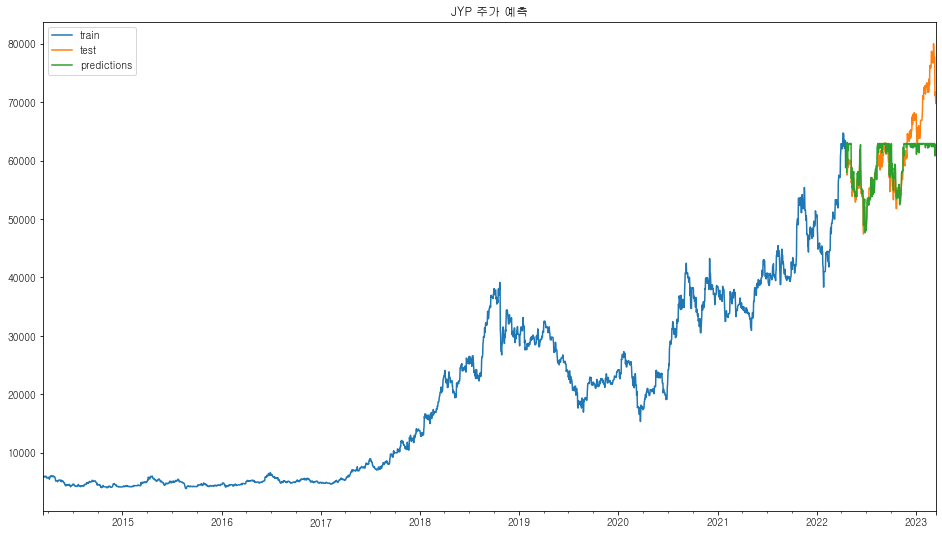

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.9),0].plot(ax=ax, label='train')
jyp_test['종가'].plot(ax=ax, label='test')
jyp_pred.plot(ax=ax, label='predictions')
ax.set_title('JYP 주가 예측')
ax.legend()

### YG

In [18]:
yg_forecaster = ForecasterAutoreg(
                 regressor     = LGBMRegressor(random_state=123),
                 lags          = 10,
                 transformer_y = StandardScaler(),
                 transformer_exog= StandardScaler()
             )

yg_forecaster.fit(y=yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.9),0],exog=yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.9),1:])

In [19]:
yg_pred=jyp_forecaster.predict(steps=round(len(yg_stock_for_sk)*0.1),
                             exog=yg_test[['오픈', '고가', '저가', '거래량', '변동 %']])

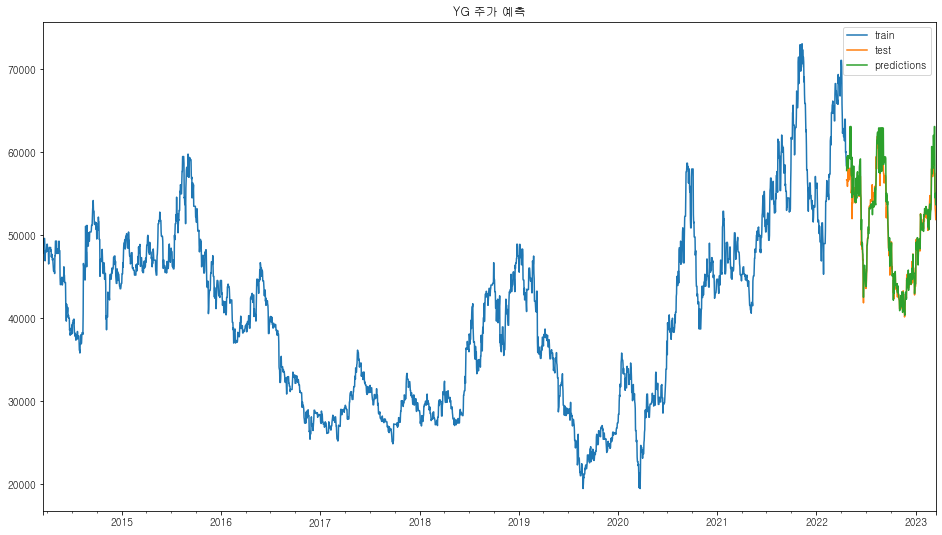

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.9),0].plot(ax=ax, label='train')
yg_test['종가'].plot(ax=ax, label='test')
yg_pred.plot(ax=ax, label='predictions')
ax.set_title('YG 주가 예측')
ax.legend()

# Hyper Parameters Tuning using Grid Search

## Parameter & Lags

In [21]:
param_grid = {
    'n_estimators': [100, 250 ,500],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1]
}

lags_grid = [20, [1, 2, 3, 5, 7, 10, 13, 17, 20]]

## Using Grid Search

### SM

In [22]:
sm_results_grid = grid_search_forecaster(
                        forecaster         = sm_forecaster,
                        y                  = sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.9),0],
                        exog               = sm_stock_for_sk.iloc[:round(len(sm_stock_for_sk)*0.9),1:],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = round(len(sm_stock_for_sk)*0.1),
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(sm_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
              )

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:16<00:00,  8.49s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  5  7 10 13 17 20] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 141357052.5058961



### JYP

In [23]:
jyp_results_grid = grid_search_forecaster(
                        forecaster         = jyp_forecaster,
                        y                  = jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.9),0],
                        exog               = jyp_stock_for_sk.iloc[:round(len(jyp_stock_for_sk)*0.9),1:],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = round(len(jyp_stock_for_sk)*0.1),
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(jyp_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
              )

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:18<00:00,  9.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  5  7 10 13 17 20] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 57064612.78356682



### YG

In [24]:
yg_results_grid = grid_search_forecaster(
                        forecaster         = yg_forecaster,
                        y                  = yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.9),0],
                        exog               = yg_stock_for_sk.iloc[:round(len(yg_stock_for_sk)*0.9),1:],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = round(len(yg_stock_for_sk)*0.1),
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(yg_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
              )

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:20<00:00, 10.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  5  7 10 13 17 20] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 11373271.022526212



# Prediction Interval

## SM

In [25]:
_, sm_pred = backtesting_forecaster(
                            forecaster = sm_forecaster,
                            y          = sm_stock_for_sk['종가'],
                            initial_train_size = len(sm_train) + len(sm_val),
                            fixed_train_size   = False,
                            steps      = 7,
                            refit      = True,
                            interval   = [10, 90],
                            n_boot     = 1000,
                            metric     = 'mean_squared_error',
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2961
Number of observations used for backtesting: 329
    Number of folds: 47
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2014-03-14 00:00:00 -- 2022-04-21 00:00:00  (n=2961)
    Validation: 2022-04-22 00:00:00 -- 2022-04-28 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2014-03-14 00:00:00 -- 2022-04-28 00:00:00  (n=2968)
    Validation: 2022-04-29 00:00:00 -- 2022-05-05 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2014-03-14 00:00:00 -- 2022-05-05 00:00:00  (n=2975)
    Validation: 2022-05-06 00:00:00 -- 2022-05-12 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2014-03-14 00:00:00 -- 2022-05-12 00:00:00  (n=2982)
    Validation: 2022-05-13 00:00:00 -- 2022-05-19 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2014-03-14 00:00:00 -- 2022-05-19 00:00:00  (n=2989)
    Validation: 2022-05-20 00:

In [26]:
sm_inside_interval = np.where(
                     (sm_stock_for_sk.loc[sm_pred.index, '종가'] >= sm_pred['lower_bound']) & \
                     (sm_stock_for_sk.loc[sm_pred.index, '종가'] <= sm_pred['upper_bound']),
                     True,
                     False
                  )

sm_coverage = sm_inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * sm_coverage}")

Coverage of the predicted interval on test data: 31.61094224924012


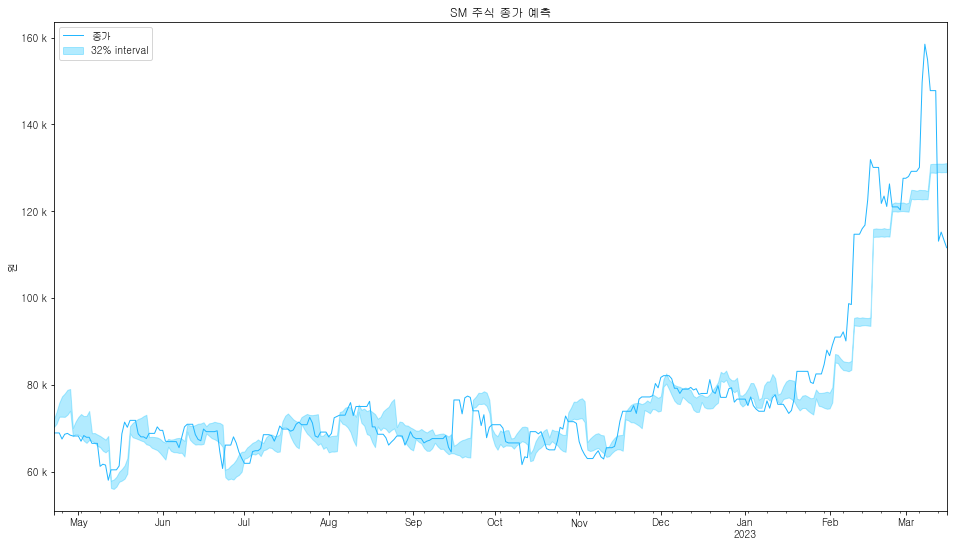

In [27]:
fig, ax=plt.subplots(figsize=(16, 9))
sm_stock_for_sk.iloc[round(len(sm_stock_for_sk)*0.9):,0].plot(ax=ax, label='종가', linewidth=1, color="#23b7ff")
ax.fill_between(
    sm_pred.index,
    sm_pred['lower_bound'],
    sm_pred['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '32% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('원')
ax.set_title('SM 주식 종가 예측')
ax.legend();

## JYP

In [28]:
_, jyp_pred = backtesting_forecaster(
                            forecaster = jyp_forecaster,
                            y          = jyp_stock_for_sk['종가'],
                            initial_train_size = len(jyp_train) + len(jyp_val),
                            fixed_train_size   = False,
                            steps      = 7,
                            refit      = True,
                            interval   = [10, 90],
                            n_boot     = 1000,
                            metric     = 'mean_squared_error',
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2961
Number of observations used for backtesting: 329
    Number of folds: 47
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2014-03-14 00:00:00 -- 2022-04-21 00:00:00  (n=2961)
    Validation: 2022-04-22 00:00:00 -- 2022-04-28 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2014-03-14 00:00:00 -- 2022-04-28 00:00:00  (n=2968)
    Validation: 2022-04-29 00:00:00 -- 2022-05-05 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2014-03-14 00:00:00 -- 2022-05-05 00:00:00  (n=2975)
    Validation: 2022-05-06 00:00:00 -- 2022-05-12 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2014-03-14 00:00:00 -- 2022-05-12 00:00:00  (n=2982)
    Validation: 2022-05-13 00:00:00 -- 2022-05-19 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2014-03-14 00:00:00 -- 2022-05-19 00:00:00  (n=2989)
    Validation: 2022-05-20 00:

In [29]:
jyp_inside_interval = np.where(
                     (jyp_stock_for_sk.loc[jyp_pred.index, '종가'] >= jyp_pred['lower_bound']) & \
                     (jyp_stock_for_sk.loc[jyp_pred.index, '종가'] <= jyp_pred['upper_bound']),
                     True,
                     False
                  )

jyp_coverage = jyp_inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * jyp_coverage}")

Coverage of the predicted interval on test data: 17.933130699088146


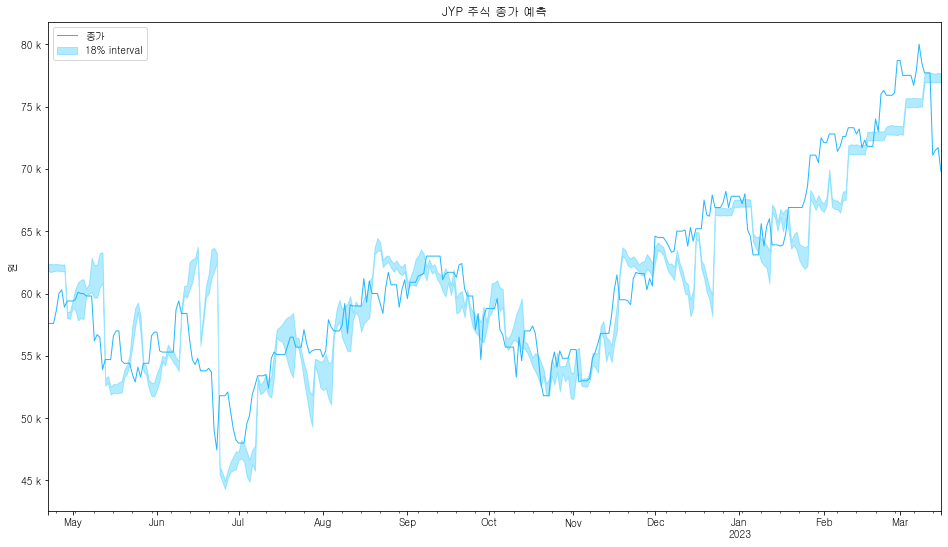

In [30]:
fig, ax=plt.subplots(figsize=(16, 9))
jyp_stock_for_sk.iloc[round(len(jyp_stock_for_sk)*0.9):,0].plot(ax=ax, label='종가', linewidth=1, color="#23b7ff")
ax.fill_between(
    jyp_pred.index,
    jyp_pred['lower_bound'],
    jyp_pred['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '18% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('원')
ax.set_title('JYP 주식 종가 예측')
ax.legend();

## YG

In [31]:
_, yg_pred = backtesting_forecaster(
                            forecaster = yg_forecaster,
                            y          = yg_stock_for_sk['종가'],
                            initial_train_size = len(yg_train) + len(yg_val),
                            fixed_train_size   = False,
                            steps      = 7,
                            refit      = True,
                            interval   = [10, 90],
                            n_boot     = 1000,
                            metric     = 'mean_squared_error',
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2958
Number of observations used for backtesting: 329
    Number of folds: 47
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2014-03-17 00:00:00 -- 2022-04-21 00:00:00  (n=2958)
    Validation: 2022-04-22 00:00:00 -- 2022-04-28 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2014-03-17 00:00:00 -- 2022-04-28 00:00:00  (n=2965)
    Validation: 2022-04-29 00:00:00 -- 2022-05-05 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2014-03-17 00:00:00 -- 2022-05-05 00:00:00  (n=2972)
    Validation: 2022-05-06 00:00:00 -- 2022-05-12 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2014-03-17 00:00:00 -- 2022-05-12 00:00:00  (n=2979)
    Validation: 2022-05-13 00:00:00 -- 2022-05-19 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2014-03-17 00:00:00 -- 2022-05-19 00:00:00  (n=2986)
    Validation: 2022-05-20 00:

In [32]:
yg_inside_interval = np.where(
                     (yg_stock_for_sk.loc[yg_pred.index, '종가'] >= yg_pred['lower_bound']) & \
                     (yg_stock_for_sk.loc[yg_pred.index, '종가'] <= yg_pred['upper_bound']),
                     True,
                     False
                  )

yg_coverage = yg_inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * yg_coverage}")

Coverage of the predicted interval on test data: 33.73860182370821


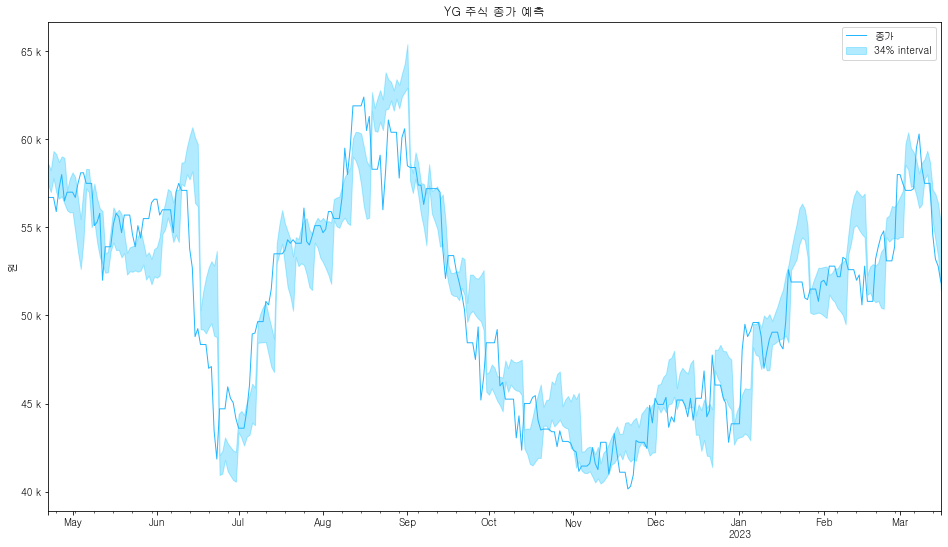

In [33]:
fig, ax=plt.subplots(figsize=(16, 9))
yg_stock_for_sk.iloc[round(len(yg_stock_for_sk)*0.9):,0].plot(ax=ax, label='종가', linewidth=1, color="#23b7ff")
ax.fill_between(
    yg_pred.index,
    yg_pred['lower_bound'],
    yg_pred['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '34% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('원')
ax.set_title('YG 주식 종가 예측')
ax.legend();

# Future Stock Prediction

## SM

In [34]:
sm_forecaster.fit(y=sm_stock_for_sk['종가'])

In [35]:
sm_future_pred=sm_forecaster.predict(steps=7)

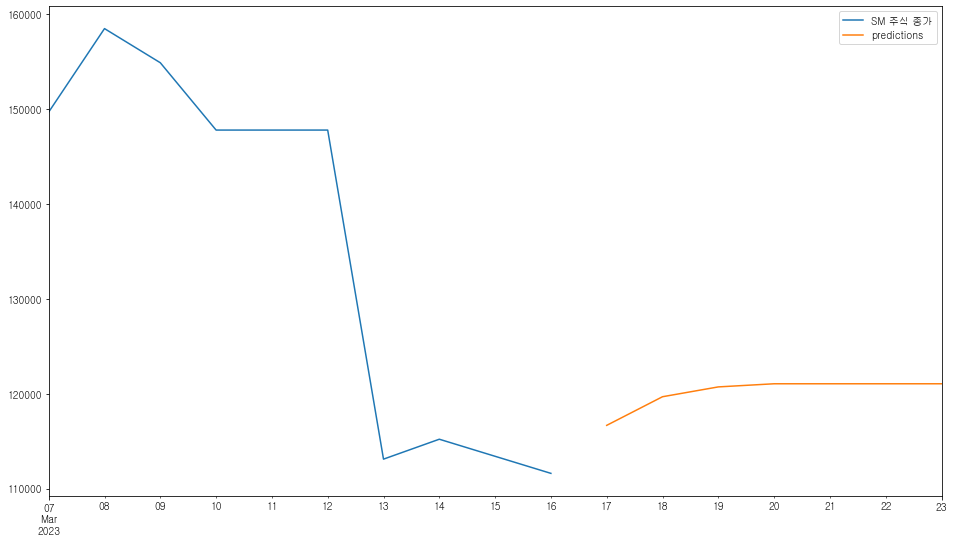

In [36]:
fig, ax = plt.subplots(figsize=(16, 9))
sm_stock_for_sk.iloc[-10:,0].plot(ax=ax, label='SM 주식 종가')
sm_future_pred.plot(ax=ax, label='predictions')
ax.legend()

### JYP

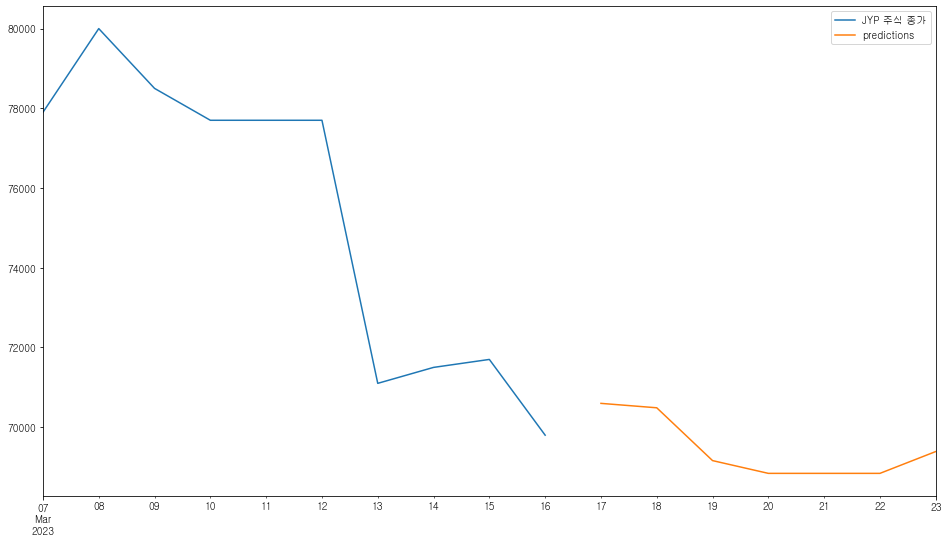

In [37]:
jyp_forecaster.fit(y=jyp_stock_for_sk['종가'])
jyp_future_pred=jyp_forecaster.predict(steps=7)
fig, ax = plt.subplots(figsize=(16, 9))
jyp_stock_for_sk.iloc[-10:,0].plot(ax=ax, label='JYP 주식 종가')
jyp_future_pred.plot(ax=ax, label='predictions')
ax.legend()

## YG

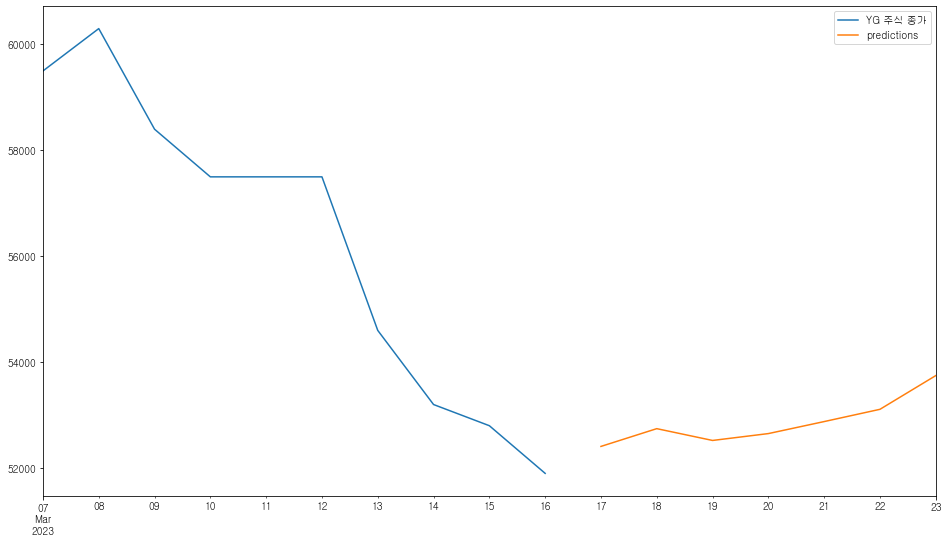

In [38]:
yg_forecaster.fit(y=yg_stock_for_sk['종가'])
yg_future_pred=yg_forecaster.predict(steps=7)
fig, ax = plt.subplots(figsize=(16, 9))
yg_stock_for_sk.iloc[-10:,0].plot(ax=ax, label='YG 주식 종가')
yg_future_pred.plot(ax=ax, label='predictions')
ax.legend()